<a href="https://colab.research.google.com/github/waleligntewabe/TTS/blob/main/Wallet_Amharic_Amharic_TTS_Version2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning SpeechT5 for multilingual TTS

This notebook demonstrates how to fine-tune the SpeechT5 model from 🤗 Transformers on the **text-to-speech** task.

The unique thing about SpeechT5 is that the model is first pre-trained on a combination of speech-to-text and text-to-speech data, so that it learns a unified space of hidden representations shared by both text and speech. This allows us to fine-tune the same pretrained model on different tasks. Read more about SpeechT5 [in our blog post](https://huggingface.co/blog/speecht5).

In this notebook we will start from an existing fine-tuned TTS model that was originally trained on English speech from LibriTTS, and fine-tune it for the Dutch language using the VoxPopuli dataset.

This TTS model will support multiple speakers through x-vector speaker embeddings.

## Install required packages

We install Transformers from GitHub since not all the SpeechT5 features we need have been merged into an official release yet.


In [ ]:
!pip install datasets soundfile speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 18.4 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-n8dod4jh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-n8dod4jh
  Resolved https://github.com/huggingface/transformers.git to commit 4a66c0d95219bbeb91bebd010d75a29a5e5f3f43
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.37.0.dev0-py3-none-any.whl size=8311063 sha256=20203fca44273459e6c53043dc38dfcd0f92d1c7c0d96aa6ee80a69bc6ddb523
  Stored in directory: /tmp/pip-ephem-wheel-cache-s9tmelei/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00


Do we have a GPU?

In [ ]:
!nvidia-smi

Thu Jan  4 12:32:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In case no GPU is found, from the menu choose **Runtime > Change runtime type** and set **Hardware accelerator** to **GPU**. Then restart the runtime to activate the GPU.

## Load the model

We'll start from SpeechT5 that's already been fine-tuned for English TTS, and fine-tune it again but for a new language. For more info about the original checkpoint, you can find its model card on the [Hugging Face Hub](https://huggingface.co/microsoft/speecht5_tts).

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Load the dataset

We'll fine-tune on the Dutch (language code `nl`) examples from VoxPopuli.

VoxPopuli is a large-scale multilingual speech corpus consisting of data sourced from 2009-2020 European Parliament event recordings. It contains labelled audio-transcription data for 15 European languages.

You can find [VoxPopuli on the Hugging Face Hub](https://huggingface.co/datasets/facebook/voxpopuli). There, you can listen to audio samples in any one of the 15 European languages using the dataset previewer.

Note that VoxPopuli, or any other automatic speech recognition (ASR) dataset, is not necessarily the best dataset to use for TTS training. The qualities that make it useful for ASR, such as lots of noise in the sound, are usually what we want to avoid in TTS. But high-quality, multilingual, multi-speaker TTS datasets are less easy to find than ASR datasets.

In [ ]:
from datasets import load_dataset, Audio

In [ ]:
'''
from datasets import load_dataset, Audio

dataset = load_dataset(
    "facebook/voxpopuli", "nl", split="train"
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/EduAiHub/SpeechT5/SpeechT5/metadata.csv')

In [ ]:
# Assuming your folder of WAV files is named 'audio_folder'
import os
audio_folder_path = '/content/drive/MyDrive/EduAiHub/SpeechT5/SpeechT5/wav'

# Function to get the file paths for each audio_id
def get_audio_file_path(audio_id):
    return os.path.join(audio_folder_path, f"{audio_id}")

# Apply the function to create a new 'audio' column
#df['audio'] = ''
df['audio'] = df['audio_id'].apply(get_audio_file_path)

In [ ]:
df

,audio_id,language,audio,raw_text,normalized_text,gender,speaker_id,is_gold_transcript,accent
0,AM 00001.wav,9,/content/drive/MyDrive/EduAiHub/SpeechT5/Speec...,የእግዚአብሔርን ስም የሚጠራ ሁሉ ይድናል,የእግዚአብሔርን ስም የሚጠራ ሁሉ ይድናል,male,1120,True,None
1,AM 00002.wav,9,/content/drive/MyDrive/EduAiHub/SpeechT5/Speec...,እግዚአብሔርም ብርሃኑን ቀን ብሎ ጠራው ጨለማውንም ሌሊት አለው,እግዚአብሔርም ብርሃኑን ቀን ብሎ ጠራው ጨለማውንም ሌሊት አለው,male,1120,True,None
2,AM 00003.wav,9,/content/drive/MyDrive/EduAiHub/SpeechT5/Speec...,እግዚአብሔርም በምድር ላይ ያበሩ ዘንድ በሰማይ ጠፈር አኖራቸው,እግዚአብሔርም በምድር ላይ ያበሩ ዘንድ በሰማይ ጠፈር አኖራቸው,male,1120,True,None
3,AM 00004.wav,9,/content/drive/MyDrive/EduAiHub/SpeechT5/Speec...,ሰማይና ምድር ሠራዊታቸውም ሁሉ ተፈጸሙ,ሰማይና ምድር ሠራዊታቸውም ሁሉ ተፈጸሙ,male,1120,True,None
4,AM 00005.wav,9,/content/drive/MyDrive/EduAiHub/SpeechT5/Speec...,እግዚአብሔር አምላክ በምሥራቅ በዔደን ገነትን ተከለ የፈጠረውንም ሰው ከዚ...,እግዚአብሔር አምላክ በምሥራቅ በዔደን ገነትን ተከለ የፈጠረውንም ሰው ከዚ...,male,1120,True,None
...,...,...,...,...,...,...,...,...,...
10990,AM 17414.wav,9,/content/drive/MyDrive/EduAiHub/SpeechT5/Speec...,ቀ ሩ ሢ ታ ቼ ኀ ጶ,ቀ ሩ ሢ ታ ቼ ኀ ጶ,male,1122,True,None
10991,AM 17415.wav,9,/content/drive/MyDrive/EduAiHub/SpeechT5/Speec...,ጰ ፁ ፒ ጃ ኤ ብ ጎ,ጰ ፁ ፒ ጃ ኤ ብ ጎ,male,1122,True,None
10992,AM 17416.wav,9,/content/drive/MyDrive/EduAiHub/SpeechT5/Speec...,ገ ጉ ጊ ጋ ጌ ግ ጎ,ገ ጉ ጊ ጋ ጌ ግ ጎ,male,1122,True,None
10993,AM 17417.wav,9,/content/drive/MyDrive/EduAiHub/SpeechT5/Speec...,ጰ ጱ ጲ ጳ ጴ ጵ ጶ,ጰ ጱ ጲ ጳ ጴ ጵ ጶ,male,1122,True,None


In [ ]:
# Define the schema for the dataset
# sampling_rate=16000
import datasets
dataset_schema = datasets.Features({
    'audio_id': datasets.Value('string'),
    'language': datasets.ClassLabel(names=['am','en', 'de', 'fr', 'es', 'pl', 'it', 'ro', 'hu', 'cs', 'nl', 'fi', 'hr', 'sk', 'sl', 'et', 'lt', 'en_accented']),
    'audio': datasets.Audio(sampling_rate=16000, mono=True, decode=True),
    'raw_text': datasets.Value('string'),
    'normalized_text': datasets.Value('string'),
    'gender': datasets.Value('string'),
    'speaker_id': datasets.Value('string'),
    'is_gold_transcript': datasets.Value('bool'),
    'accent': datasets.Value('string'),
})

In [ ]:
dataset_schema

{'audio_id': Value(dtype='string', id=None),
 'language': ClassLabel(names=['am', 'en', 'de', 'fr', 'es', 'pl', 'it', 'ro', 'hu', 'cs', 'nl', 'fi', 'hr', 'sk', 'sl', 'et', 'lt', 'en_accented'], id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'raw_text': Value(dtype='string', id=None),
 'normalized_text': Value(dtype='string', id=None),
 'gender': Value(dtype='string', id=None),
 'speaker_id': Value(dtype='string', id=None),
 'is_gold_transcript': Value(dtype='bool', id=None),
 'accent': Value(dtype='string', id=None)}

In [ ]:
!pip install -qqq datasets

In [ ]:
# Create a new dataset using the specified schema
new_dataset = datasets.Dataset.from_pandas(df, features=dataset_schema)

In [ ]:
# Display the dataset information
print(new_dataset)

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 10995
})


In [ ]:
dataset = new_dataset

It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.

In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
print(dataset)

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 10995
})


Let's quickly check how many examples are in this dataset.

In [ ]:
len(dataset)

10995

That should be sufficient for fine-tuning. We'll have a closer look at these examples soon.

## Clean up the text

The dataset may contain characters that are not in the SpeechT5 tokenizer vocabulary. Those will be converted to `<unk>` tokens. However, in Dutch a character such as `à` is used to stress syllables and so we can simply replace it with `a` without changing its meaning. The tokenizer supports some characters with diacritical marks, such as `é`, but not all of them.

Note that the VoxPopuli examples have both `raw_text` and `normalized_text`, which is all lowercase. The SpeechT5 tokenizer can handle uppercase just fine, however, it doesn't have any tokens for numbers. The `normalized_text` has the numbers written out as text, so we'll use that.



First we'll need to find out what the unsupported tokens are. The `SpeechT5Tokenizer` works with characters as tokens, so let's extract all distinct characters of the dataset. We write a mapping function `extract_all_chars` that concatenates the transcriptions from all examples into one long transcription and then transforms the string into a set of characters. It is important to pass the arguments `batched=True` and `batch_size=-1` to `dataset.map(...)` so that the mapping function has access to all transcriptions at once.

In [ ]:
tokenizer = processor.tokenizer

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [ ]:
dataset_vocab - tokenizer_vocab

{' ',
 '%',
 '*',
 '+',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '_',
 '|',
 '\xa0',
 '«',
 '»',
 '÷',
 'ז',
 'ח',
 'ע',
 'ሀ',
 'ሁ',
 'ሂ',
 'ሃ',
 'ሄ',
 'ህ',
 'ሆ',
 'ለ',
 'ሉ',
 'ሊ',
 'ላ',
 'ሌ',
 'ል',
 'ሎ',
 'ሏ',
 'ሐ',
 'ሑ',
 'ሒ',
 'ሓ',
 'ሔ',
 'ሕ',
 'ሖ',
 'መ',
 'ሙ',
 'ሚ',
 'ማ',
 'ሜ',
 'ም',
 'ሞ',
 'ሟ',
 'ሠ',
 'ሡ',
 'ሢ',
 'ሣ',
 'ሤ',
 'ሥ',
 'ሦ',
 'ረ',
 'ሩ',
 'ሪ',
 'ራ',
 'ሬ',
 'ር',
 'ሮ',
 'ሯ',
 'ሰ',
 'ሱ',
 'ሲ',
 'ሳ',
 'ሴ',
 'ስ',
 'ሶ',
 'ሷ',
 'ሸ',
 'ሹ',
 'ሺ',
 'ሻ',
 'ሼ',
 'ሽ',
 'ሾ',
 'ሿ',
 'ቀ',
 'ቁ',
 'ቂ',
 'ቃ',
 'ቄ',
 'ቅ',
 'ቆ',
 'ቈ',
 'ቊ',
 'ቋ',
 'ቍ',
 'ቐ',
 'በ',
 'ቡ',
 'ቢ',
 'ባ',
 'ቤ',
 'ብ',
 'ቦ',
 'ቧ',
 'ቨ',
 'ቩ',
 'ቪ',
 'ቫ',
 'ቬ',
 'ቭ',
 'ቮ',
 'ቯ',
 'ተ',
 'ቱ',
 'ቲ',
 'ታ',
 'ቴ',
 'ት',
 'ቶ',
 'ቷ',
 'ቸ',
 'ቹ',
 'ቺ',
 'ቻ',
 'ቼ',
 'ች',
 'ቾ',
 'ቿ',
 'ኀ',
 'ኁ',
 'ኃ',
 'ኄ',
 'ኅ',
 'ኋ',
 'ነ',
 'ኑ',
 'ኒ',
 'ና',
 'ኔ',
 'ን',
 'ኖ',
 'ኗ',
 'ኘ',
 'ኙ',
 'ኚ',
 'ኛ',
 'ኜ',
 'ኝ',
 'ኞ',
 'ኟ',
 'አ',
 'ኡ',
 'ኢ',
 'ኣ',
 'ኤ',
 'እ',
 'ኦ',
 'ከ',
 'ኩ',
 'ኪ',
 'ካ',
 'ኬ',
 'ክ',
 'ኮ',
 'ኰ',
 'ኳ',
 

Next, we will define a function to map these characters to valid tokens and then run it on the dataset. No need to handle space, that's already replaced by `▁` in the tokenizer.

In [ ]:
replacements = [
    ('ሀ', 'ሐ'),
    ('ሁ', 'ሑ'),
    ('ሂ', 'ሒ'),
    ('ሃ', 'ሓ'),
    ('ሄ', 'ሔ'),
    ('ህ', 'ሕ'),
    ('ሆ', 'ሖ'),
    ('ሀ', 'ኀ'),
    ('ሁ', 'ኁ'),
    ('ሂ', 'ኂ'),
    ('ሃ', 'ኃ'),
    ('ሄ', 'ኄ'),
    ('ህ', 'ኅ'),
    ('ሆ', 'ኆ'),
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

In [ ]:
len(dataset)

10995

## Speakers

VoxPopuli is a multi-speaker dataset. We know there are 20968 examples in the dataset, but how many speakers are there and how many examples do they have?

In [ ]:
from collections import defaultdict
speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1


In [ ]:
print(speaker_id)

1122


In [ ]:
speaker_counts

defaultdict(int,
            {'1120': 10, '1121': 10, '1123': 10, '1124': 5, '1122': 10960})

By plotting a histogram we can get a sense of how much data there is for each speaker.

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=5)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

NameError: ignored

<Figure size 640x480 with 0 Axes>

Around one-third of speakers has fewer than 100 examples. Approximately ten or so speakers have more than 500 examples. To speed up training, let's limit ourselves to speakers that have between 100 and 400 examples. This also makes the dataset more balanced.

In [ ]:
def select_speaker(speaker_id):
    return 1 <= speaker_counts[speaker_id] <= 11000
    #return 100 <= speaker_counts[speaker_id] <= 400

dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/10995 [00:00<?, ? examples/s]

How many speakers remain?

And how many examples?

In [ ]:
len(set(dataset["speaker_id"]))

5

Just under 10k examples and ~40 unique speakers, which should be plenty.

Note: Even better would be to include the lengths of the examples. It's quite possible that speakers with few examples have plenty of audio available if these examples are relatively long. But it takes a while to scan through the entire dataset to find this information (since that requires loading and decoding each audio file), which is why we're skipping it here.

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we'll need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [ ]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

Note: the `speechbrain/spkrec-xvect-voxceleb` model was trained on English speech from the VoxCeleb dataset, while our training examples are in Dutch. We're assuming here that this model will still make reasonable speaker embeddings, but this may not be true. First training an X-vector model on the target speech, such as Dutch, might work better.

## Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

In [ ]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Let's verify the processing is correct by looking at a single example:

In [ ]:
processed_example = prepare_dataset(dataset[0])

This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [ ]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [ ]:
tokenizer.decode(processed_example["input_ids"])

'<unk><unk><unk><unk><unk></s>'

Speaker embeddings should be a 512-element vector:

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

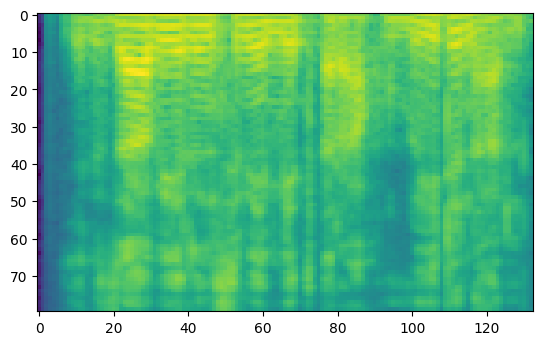

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [ ]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [ ]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

That all looks and sounds good! We can now process the entire dataset. This will take between 5 and 10 minutes.

12:10

In [ ]:
dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_read at 0x791ad6c7e680>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/soundfile.py", line 1246, in vio_read
    data_read = file.readinto(buf)
KeyboardInterrupt: 


LibsndfileError: ignored

In [ ]:
dataset.save_to_disk("/content/drive/MyDrive/EduAiHub/SpeechT5/test2.hf")

Saving the dataset (0/4 shards):   0%|          | 0/10995 [00:00<?, ? examples/s]

# load_from_disk

In [ ]:
from datasets import load_dataset,load_from_disk
dataset = load_from_disk("/content/drive/MyDrive/EduAiHub/SpeechT5/test2.hf")

Some of the examples in the dataset are apparently longer than the maximum input length the model can handle (600 tokens), so we should remove those from the dataset. In fact, to allow for larger batch sizes we'll remove anything over 200 tokens.

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

In [ ]:
dataset.shape

(10995, 3)

How many examples are left?

In [ ]:
len(dataset)

10995

## Train/test split

Create a basic train/test split. For our purposes, it's OK if the same speaker is part of both sets.

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

What does the dataset look like now?

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 9895
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 1100
    })
})

## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any
    model: Any  # Add the model as an attribute of the class

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = self.processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if self.model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % self.model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        # Ensure speaker embeddings are correctly shaped for batch processing
        batch["speaker_embeddings"] = torch.stack(speaker_features)

        return batch


In [ ]:
#New
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        speaker_embeddings_tensor = torch.tensor(speaker_features)

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        # Unsqueezing and expanding to match inputs_embeds shape
        speaker_embeddings_tensor = speaker_embeddings_tensor.unsqueeze(1).expand(-1, 20, -1)
        batch["speaker_embeddings"] = speaker_embeddings_tensor

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [ ]:
data_collator

TTSDataCollatorWithPadding(processor=SpeechT5Processor:
- feature_extractor: SpeechT5FeatureExtractor {
  "do_normalize": false,
  "feature_extractor_type": "SpeechT5FeatureExtractor",
  "feature_size": 1,
  "fmax": 7600,
  "fmin": 80,
  "frame_signal_scale": 1.0,
  "hop_length": 16,
  "mel_floor": 1e-10,
  "num_mel_bins": 80,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "SpeechT5Processor",
  "reduction_factor": 2,
  "return_attention_mask": true,
  "sampling_rate": 16000,
  "win_function": "hann_window",
  "win_length": 64
}

- tokenizer: SpeechT5Tokenizer(name_or_path='microsoft/speecht5_tts', vocab_size=79, model_max_length=600, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=Fals

Let's test the data collator.

In [ ]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [ ]:
batch

{'input_ids': tensor([[4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
         4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 2, 1, 1, 1, 1],
        [4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
         4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 2],
        [4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
         4, 3, 4, 3, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'labels': tensor([[[  -6.5859,   -6.5069

In [ ]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 45]),
 'attention_mask': torch.Size([3, 45]),
 'labels': torch.Size([3, 802, 80]),
 'speaker_embeddings': torch.Size([3, 20, 512])}

Looks good!

## Training

It's always a good idea to upload model checkpoints directly to the [Hugging Face Hub](https://huggingface.co/) while training. To allow this, first log in to the Hub by entering your Hub authentication token:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [ ]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./Wallet_Amharic_TTS",#"./speecht5_tts_amharic",  # change to a repo name of your choice

    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-05,
    max_steps=16000,
    warmup_steps=2000,
    logging_steps=25,
    save_steps=1000,
    fp16=True,
    eval_steps=1000,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to=["tensorboard"],

)

Create the trainer object using the model, dataset, and data collator.

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

And with that, we're ready to start training!

Training will take several hours depending on your GPU or the one allocated to the Google Colab. Depending on your GPU, it is possible that you will encounter a CUDA "out-of-memory" error when you start training. In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2 and increase `gradient_accumulation_steps` by 2x to compensate.

# New

In [ ]:
from transformers import Speech2TextProcessor
processor = Speech2TextProcessor.from_pretrained("your_processor_model")

def preprocess_function(examples):
    # Assuming examples['audio'] and examples['speaker_id'] exist
    input_values = processor(examples['audio'], sampling_rate=16000).input_values
    speaker_embeddings = ... # Your logic to get speaker embeddings

    # Pad input_values and speaker_embeddings to have the same sequence length
    # You might need to write a custom padding function based on your data

    return {
        "input_values": input_values,
        "speaker_embeddings": speaker_embeddings,
        # include other necessary fields
    }


OSError: ignored

In [ ]:
if speaker_embeddings.size(1) != inputs_embeds.size(1):
    # Assuming the mismatch is in the sequence length dimension
    speaker_embeddings = speaker_embeddings.expand(-1, inputs_embeds.size(1), -1)

NameError: ignored

In [ ]:
from transformers import SpeechT5Model
import torch

class CustomSpeechT5Model(SpeechT5Model):
    def forward(self, input_values, speaker_embeddings, **kwargs):
        # Print the shapes of the tensors
        print("input_values shape:", input_values.size())
        print("speaker_embeddings shape:", speaker_embeddings.size())

        # Call the original forward method
        return super().forward(input_values, speaker_embeddings, **kwargs)

# Replace the original model with your custom model
model = CustomSpeechT5Model.from_pretrained("Walelign/speecht5_tts_Amharic")

# Rest of your training code...


config.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

In [ ]:
print("inputs_embeds shape:", inputs_embeds.shape)
print("speaker_embeddings shape:", speaker_embeddings.shape)

NameError: ignored

In [ ]:
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Existing code for collating inputs and labels...

        # Modify speaker embeddings shape
        speaker_features = [feature["speaker_embeddings"] for feature in features]
        speaker_embeddings_tensor = torch.tensor(speaker_features)

        # Assuming inputs_embeds would be of shape [batch_size, seq_length, embedding_size]
        # and speaker_embeddings needs to be of shape [batch_size, seq_length, speaker_embedding_size]
        # Unsqueezing and expanding to match inputs_embeds shape
        speaker_embeddings_tensor = speaker_embeddings_tensor.unsqueeze(1).expand(-1, max_seq_length, -1)

        batch["speaker_embeddings"] = speaker_embeddings_tensor

        return batch


# Old

In [ ]:
'''
for name, module in model.named_modules():
    print(name)
    if 'some_relevant_identifier' in name:  # Replace with a relevant identifier
        print(name)



speecht5
speecht5.encoder
speecht5.encoder.prenet
speecht5.encoder.prenet.embed_tokens
speecht5.encoder.prenet.encode_positions
speecht5.encoder.prenet.encode_positions.dropout
speecht5.encoder.wrapped_encoder
speecht5.encoder.wrapped_encoder.layer_norm
speecht5.encoder.wrapped_encoder.dropout
speecht5.encoder.wrapped_encoder.layers
speecht5.encoder.wrapped_encoder.layers.0
speecht5.encoder.wrapped_encoder.layers.0.attention
speecht5.encoder.wrapped_encoder.layers.0.attention.k_proj
speecht5.encoder.wrapped_encoder.layers.0.attention.v_proj
speecht5.encoder.wrapped_encoder.layers.0.attention.q_proj
speecht5.encoder.wrapped_encoder.layers.0.attention.out_proj
speecht5.encoder.wrapped_encoder.layers.0.dropout
speecht5.encoder.wrapped_encoder.layers.0.layer_norm
speecht5.encoder.wrapped_encoder.layers.0.feed_forward
speecht5.encoder.wrapped_encoder.layers.0.feed_forward.intermediate_dropout
speecht5.encoder.wrapped_encoder.layers.0.feed_forward.intermediate_dense
speecht5.encoder.wrapped

In [ ]:
'''
def print_shapes(module, input, output):
    print(f"Layer: {module.__class__.__name__}")
    for i, inp in enumerate(input):
        print(f"Input {i} size:", inp.size())
    print("Output size:", output.data.size())

# Replace 'layer_name' with the actual name of the suspected layer
layer = dict(model.named_modules())['speecht5.decoder.wrapped_decoder.layers']
hook = layer.register_forward_hook(print_shapes)


In [ ]:
'''
def print_shapes(module, input, output):
    print(f"Layer: {module.__class__.__name__}")
    for i, inp in enumerate(input):
        print(f"Input {i} size:", inp.size())
    print("Output size:", output.data.size())

# Replace 'layer_name' with the actual name of the suspected layer
layer = dict(model.named_modules())['speecht5.decoder.wrapped_decoder.layers']
hook = layer.register_forward_hook(print_shapes)
hook.remove()

In [ ]:
trainer.train()

RuntimeError: ignored

If we do one more `push_to_hub()` after training we can get a nice model card built for us. We simply have to set the appropriate keyword arguments (kwargs). You can change these values to match your dataset, language and model name accordingly:

In [ ]:
#old
'''
kwargs = {
    "dataset_tags": "facebook/voxpopuli",
    "dataset": "tigabu",  # a 'pretty' name for the training dataset
    "dataset_args": "config: nl, split: train",
    "language": "nl",
    "model_name": "SpeechT5 TTS Amharic",  # a 'pretty' name for your model
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "tags": "",
}

In [ ]:
#New
kwargs = {
    "dataset_tags": "facebook/voxpopuli",
    "dataset": "tigabu",  # a 'pretty' name for the training dataset
    "dataset_args": "config: nl, split: train",
    "language": "nl",
    "model_name": "Wallet Amharic TTS",  # a 'pretty' name for your model
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "tags": ["amharic", "text-to-speech", "speecht5", "tts"],  # example tags, adjust as appropriate
}




The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command:

In [ ]:
trainer.push_to_hub(**kwargs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/Walelign/Wallet_Amharic_TTS/commit/5f2bc806c9335118679e9d42b34ed6e631b3fdca', commit_message='End of training', commit_description='', oid='5f2bc806c9335118679e9d42b34ed6e631b3fdca', pr_url=None, pr_revision=None, pr_num=None)

You can now share this model with anyone using the link on the Hub.

## Evaluate

After training finishes, let's use the model to synthesize some speech!

I'm loading the model from the Hugging Face Hub, as the Colab notebook was terminated before training finished (which is why it's a good idea to use `push_to_hub=True` when training).

In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained("Walelign/Wallet_Amharic_TTS") #Matthijs

config.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

First we need to obtain a speaker embedding. We can simply grab one from the test set.

In [ ]:
example = dataset["test"][304]  # This is the orginal
#example = dataset["test"][1]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

Define some input text and tokenize it.

In [ ]:
#text = "የእግዚአብሔር ስም ያድናል"
text = "ያለፍርድ ቤት ትዕዛዝ የሰው ቤት በርብረዋል በሚል ወንጀል የተጠረጠሩ ሦስት የሚሊሻ አባላት ክስ ተመሰረተባቸው"

In [ ]:
tokenizer.decode(tokenizer(text)["input_ids"])

'<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk></s>'

In [ ]:
inputs = processor(text=text, return_tensors="pt")

Tell the model to generate a spectrogram from the input text.

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

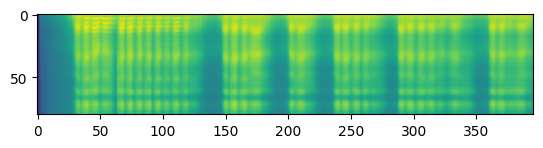

In [ ]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, use the vocoder to turn the spectrogram into sound.

In [ ]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [ ]:
import soundfile as sf
sf.write("output.wav", speech.numpy(), samplerate=16000)

In [ ]:
pip install gradio_client

In [ ]:
from gradio_client import Client

client = Client("https://huggingface-course-audio-course-u7-assessment.hf.space/--replicas/j6xkk/")
result = client.predict(
		"Howdy!",	# str  in 'Repo id or URL of your demo' Textbox component
		api_name="/predict"
)
print(result)

## Building a demo

To showcase your newly fine-tuned model, make a demo on Hugging Face Spaces! We've created a [template Gradio demo](https://huggingface.co/spaces/Matthijs/speecht5-tts-demo) that you can easily copy and make your own.

Click the link to duplicate the template demo to your account: https://huggingface.co/spaces/Matthijs/speecht5-tts-demo?duplicate=true (or from the three-dot button at the top choose **Duplicate this Space**).

We recommend giving your space a similar name to your fine-tuned model (e.g. `speecht5_tts_voxpopuli_nl`) and setting the visibility to "Public".

Once you've duplicated the Space to your account, click **Files and versions > app.py > edit**. Change the model identifier to your fine-tuned model (line 9). Scroll to the bottom of the page and click **Commit changes to main**. The demo will reboot, this time using your fine-tuned model.

You can share this demo with your friends and family so that they can use the model that you've trained!

## Conclusion

That's it, you've fine-tuned SpeechT5 for TTS on a custom dataset!

In our experience, it can be difficult to get good results out of this model. The results can be rather noisy and sometimes what the model outputs doesn't even sound like speech at all. A lot of this appears to be related to the speaker embeddings. Since SpeechT5 was pre-trained with English x-vectors, it gives the best results using those English speaker embeddings. So if the generated speech sounds bad, try using a different speaker embedding and it might improve.

Of course, the demo above was only trained for 3000 iterations. Training for longer should improve the results. Even so, the speech clearly is Dutch instead of English, and it does capture the voice characteristics of the speaker (compare to the original audio in the example).

Another thing to experiment with is the model's configuration. For example, try using `config.reduction_factor = 1` to see if this improves the results.

A final note on ethical concerns: While TTS technology has many beneficial uses, it can also be used for nefarious purposes such as imitating someone's voice without their permission. Please use TTS wisely and responsibly!

# **MMS**

In [ ]:
!pip install --upgrade transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
from transformers import VitsModel, AutoTokenizer
import torch

model = VitsModel.from_pretrained("facebook/mms-tts-amh")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-amh")

text = "some example text in the Amharic language"
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs).waveform


Some weights of the model checkpoint at facebook/mms-tts-amh were not used when initializing VitsModel: ['flow.flows.0.wavenet.res_skip_layers.2.weight_g', 'posterior_encoder.wavenet.in_layers.13.weight_g', 'posterior_encoder.wavenet.res_skip_layers.3.weight_g', 'flow.flows.3.wavenet.in_layers.3.weight_g', 'flow.flows.2.wavenet.in_layers.3.weight_g', 'flow.flows.3.wavenet.in_layers.0.weight_g', 'posterior_encoder.wavenet.res_skip_layers.0.weight_g', 'posterior_encoder.wavenet.in_layers.15.weight_v', 'flow.flows.3.wavenet.res_skip_layers.0.weight_g', 'flow.flows.3.wavenet.res_skip_layers.3.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'posterior_encoder.wavenet.in_layers.15.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'posterior_encoder.wavenet.res_skip_layers.13.weight_v', 'posterior_encoder.wavenet.in_layers.3.weight_g', 'posterior_encoder.wavenet.in_layers.2.weight_v', 'posterior_encoder.wavenet.res_skip_layers.14.weight_v', 'posterior_encoder.wavenet.res_s

In [ ]:
import scipy

scipy.io.wavfile.write("techno.wav", rate=model.config.sampling_rate, data=output)


AttributeError: 'torch.dtype' object has no attribute 'kind'

In [ ]:
from IPython.display import Audio

Audio(output, rate=model.config.sampling_rate)


In [ ]:
$ uroman.pl [-l <lang-code>] [--chart] [--no-cache] < STDIN
       where the optional <lang-code> is a 3-letter languages code, e.g. ara, bel, bul, deu, ell, eng, fas,
            grc, ell, eng, heb, kaz, kir, lav, lit, mkd, mkd2, oss, pnt, pus, rus, srp, srp2, tur, uig, ukr, yid.
       --chart specifies chart output (in JSON format) to represent alternative romanizations.
       --no-cache disables caching.

SyntaxError: invalid syntax (<ipython-input-13-d0a888df2b9e>, line 1)